In [1]:
import math
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

import roboticstoolbox as rtb
import spatialmath as sm # provides objects for representing transformations
from swift import Swift # lightweight browser-based simulator which comes with the toolbox
import spatialgeometry as sg # utility package for dealing with geometric objects

In [83]:
robot = rtb.models.wx200()

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [3]:
print(robot)

ERobot: wx200 (by Interbotix), 8 joints (RRRRRRPP), 4 branches, dynamics, geometry, collision
┌──────┬─────────────────────┬───────┬───────────────────┬───────────────────────────────────────────┐
│ link │        link         │ joint │      parent       │            ETS: parent to link            │
├──────┼─────────────────────┼───────┼───────────────────┼───────────────────────────────────────────┤
│    0 │ /base_link          │       │ BASE              │ SE3()                                     │
│    1 │ /shoulder_link      │     0 │ /base_link        │ SE3(0, 0, 0.0716) ⊕ Rz(q0)                │
│    2 │ /upper_arm_link     │     1 │ /shoulder_link    │ SE3(0, 0, 0.03865) ⊕ Ry(q1)               │
│    3 │ /forearm_link       │     2 │ /upper_arm_link   │ SE3(0.05, 0, 0.2; 180°, -0°, 0°) ⊕ Ry(q2) │
│    4 │ /wrist_link         │     3 │ /forearm_link     │ SE3(0.2, 0, 0) ⊕ Ry(q3)                   │
│    5 │ /gripper_link       │     4 │ /wrist_link       │ SE3(0.065, 0, 0; -180°,

In [ ]:
robot.ee_links

In [4]:
robot.fkine(robot.qr, end='/ee_gripper_link', )

  -0.3233    0         0.9463    0.1285    
   0         1         0         0         
  -0.9463    0        -0.3233    0.2251    
   0         0         0         1         


In [63]:
# Make the environment
env = Swift()

# Launch the simulator, will open a browser tab in your default
# browser (chrome is recommended)
# The realtime flag will ask the simulator to simulate as close as
# possible to realtime as apposed to as fast as possible
# We can also choose to see Swift within the notebook using the
# browser="notebook" flag
env.launch(realtime=True, browser="notebook")

# We can then add our robot to the simulator envionment
env.add(ob=robot)

# end-effector axes
ee_axes = sg.Axes(0.1)

# goal axes
goal_axes = sg.Axes(0.1)

# Add the axes to the environment
env.add(ee_axes)
env.add(goal_axes) 

2

In [ ]:
# We can set the pose of the shape using the `.T` attribute.
# This pose can be either a spatialmat SE3 or a 4x4 ndarray
ee_axes.T = robot.fkine(robot.q, end='/ee_gripper_link')

# Set the goal axes to something along the x axis
goal_axes.T = sm.SE3.Trans(0.5, 0.0, 0.5)

# step the environment to view the changes
env.step(0.05)

In [ ]:
# Set all joint velocities to 0.1 rad/s
robot.qd = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Step the environment 100 times with a time step of 50 milliseconds
for _ in range(100):
    env.step(0.05)

In [ ]:
# Our desired end-effector velocity
# A constant 0.1 m/s along the x-axis
ev = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0]

# The base-frame manipulator Jacobian in the qr configuration
J = robot.jacob0(robot.qr, end='/ee_arm_link')

# Calculate the required joint velocities to achieve the desired end-effector velocity ev
dq = np.linalg.pinv(J) @ ev

# Visualise the results
print(np.round(dq, 4))

In [18]:
robot.qlim

array([[-3.14159265, -1.88495559, -1.6231562 , -2.14675498, -3.14159265,
        -3.14159265,  0.015     , -0.037     ],
       [ 3.14159265,  1.97222205,  1.88495559,  1.74532925,  3.14159265,
         3.14159265,  0.037     , -0.015     ]])

In [25]:
(robot.qlim*180/np.pi).astype(np.int16)

array([[-180, -108,  -93, -123, -180, -180,    0,   -2],
       [ 180,  113,  108,  100,  180,  180,    2,    0]], dtype=int16)

In [49]:
robot.qr

array([ 0.        , -0.3       ,  0.        , -2.2       ,  0.        ,
        2.        ,  0.78539816,  0.        ])

In [57]:
# Make a new environment and add our robot
env = Swift()
env.launch(realtime=True, browser="notebook")
env.add(robot)

# Change the robot configuration to the ready position
robot.qr = np.zeros(8)
robot.q = robot.qr
dq_size = len(robot.qd) # number of actuators defined in rtb (faultily says 8 for WX200 arm, should be 6 including the fingers)
action_size = 5 # number of actuators we're actually using (5 for WX200 arm, since we dont use the fingers)

# Specify our desired end-effector velocity
ev = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

# Specify our timestep
dt = 0.001
duration = 5

max_qd = np.zeros(8)
qd_history = []

# Step the sim to view the robot in this configuration
env.step(dt)

# Run the simulation for [duration] seconds
for _ in range(int(duration/dt)):

	# Work out the manipulator Jacobian using the current robot configuration
	J = robot.jacob0(robot.q, end='/ee_arm_link')

	# Since the robot has 7 joints, the Jacobian is not square, therefore we must
	# use the pseudoinverse (the pinv method)
	J_pinv = np.linalg.pinv(J)
	
	print(J_pinv.shape, len(ev))
	# Calculate the required joint velocities and apply to the robot
	robot.qd = np.concatenate([J_pinv @ ev, np.zeros(dq_size - action_size)])
	# robot.qd = np.zeros(8)
	# robot.qd[5] = 1.0
 
	max_qd = np.max(np.vstack([abs(robot.qd), max_qd]), axis=0)
	qd_history.append(np.copy(robot.q))

	# Step the simulator by dt seconds
	env.step(dt)

(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(

In [51]:
robot.q = robot.qr
env.step(dt)

In [58]:
qd_history = np.array(qd_history)

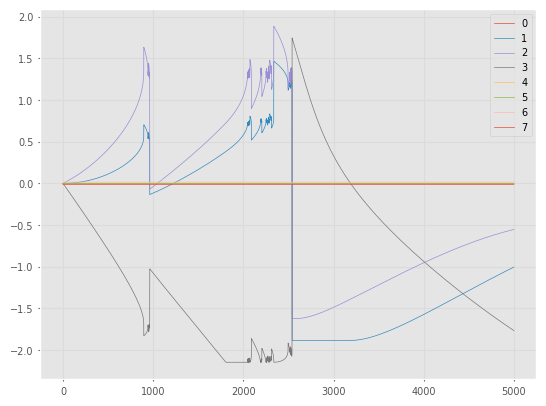

In [59]:
plt.plot(qd_history, label=np.arange(8))
plt.legend()
plt.show()

In [60]:
def angle_axis(T: np.ndarray, Td: np.ndarray) -> np.ndarray:
    """
    Returns the error vector between T and Td in angle-axis form.

    :param T: The current pose
    :param Tep: The desired pose

    :returns e: the error vector between T and Td
    """

    e = np.empty(6)

    # The position error
    e[:3] = Td[:3, -1] - T[:3, -1]

    R = Td[:3, :3] @ T[:3, :3].T

    li = np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])

    if np.linalg.norm(li) < 1e-6:
        # If li is a zero vector (or very close to it)

        # diagonal matrix case
        if np.trace(R) > 0:
            # (1,1,1) case
            a = np.zeros((3,))
        else:
            a = np.pi / 2 * (np.diag(R) + 1)
    else:
        # non-diagonal matrix case
        ln = np.linalg.norm(li)
        a = math.atan2(ln, np.trace(R) - 1) * li / ln

    e[3:] = a

    return e

In [61]:
def p_servo(
    Te: np.ndarray, Tep: np.ndarray, gain: np.ndarray, threshold: float = 0.1
) -> Tuple[np.ndarray, bool]:
    """
    Position-based servoing.

    Returns the end-effector velocity which will cause the robot to approach
    the desired pose.

    :param Te: The current pose of the end-effecor in the base frame.
    :type wTe: ndarray
    :param Tep: The desired pose of the end-effecor in the base frame.
    :type wTep: ndarray
    :param gain: The gain for the controller. A vector corresponding to each
        Cartesian axis.
    :type gain: array-like
    :param threshold: The threshold or tolerance of the final error between
        the robot's pose and desired pose
    :type threshold: float

    :returns v: The velocity of the end-effector which will casue the robot
        to approach Tep
    :rtype v: ndarray(6)
    :returns arrived: True if the robot is within the threshold of the final
        pose
    :rtype arrived: bool
    """

    # Calculate the pose error vector
    e = angle_axis(Te, Tep)

    # Construct our gain diagonal matrix
    k = np.diag(gain)

    # Calculate our desired end0effector velocity
    v = k @ e

    # Check if we have arrived
    arrived = True if np.sum(np.abs(e)) < threshold else False

    return v, arrived


   1         0         0         0         
   0         1         0         0         
   0         0         1         0         
   0         0         0         1         


In [91]:
init_robotbase = robot.base.copy()

In [93]:
# Make a new environment and add our robot
env = Swift()
env.launch(realtime=True, browser="notebook")
env.add(robot)
env.add(ee_axes)
env.add(goal_axes)

# Change the robot configuration to the ready position
robot.base = init_robotbase.copy()
robot.qr = np.zeros(8)
robot.q = robot.qr

# Step the sim to view the robot in this configuration
env.step(0)

# A variable to specify when to break the loop
arrived = False

# Specify the gain for the p_servo method
gain = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Specify our timestep
dt = 0.05

Tep = robot.base * sm.SE3.RPY(0.0, 0.0, 0.0) * sm.SE3.Trans(0.3, 0, 0.2)
Tep = Tep.A

# Set the goal axes to Tep
goal_axes.T = Tep

# Run the simulation until the robot arrives at the goal
while not arrived:

    # Work out the base frame manipulator Jacobian using the current robot configuration
    J = robot.jacob0(robot.q, end='/ee_arm_link')

    # The end-effector pose of the robot (using .A to get a numpy array instead of an SE3 object)
    Te = robot.fkine(robot.q, end='/ee_arm_link').A

    # Since the robot has 7 joints, the Jacobian is not square, therefore we must
    # use the pseudoinverse (the pinv method)
    J_pinv = np.linalg.pinv(J)

    # Calculate the required end-effector velocity and whether the robot has arrived
    ev, arrived = p_servo(Te, Tep, gain=gain, threshold=0.001)

    # Calculate the required joint velocities and apply to the robot
    # robot.qd = J_pinv @ ev
    robot.qd = np.concatenate([J_pinv @ ev, np.zeros(dq_size - action_size)])

    # Update the ee axes
    ee_axes.T = Te
    
    robot.base = robot.base * sm.SE3.Trans(0.0,0.001,0)

    # Step the simulator by dt seconds
    env.step(dt)

connection handler failed
Traceback (most recent call last):
  File "/home/vikhyat/dkt-tutorial/dkt-env/lib/python3.10/site-packages/websockets/legacy/protocol.py", line 963, in transfer_data
    message = await self.read_message()
  File "/home/vikhyat/dkt-tutorial/dkt-env/lib/python3.10/site-packages/websockets/legacy/protocol.py", line 1033, in read_message
    frame = await self.read_data_frame(max_size=self.max_size)
  File "/home/vikhyat/dkt-tutorial/dkt-env/lib/python3.10/site-packages/websockets/legacy/protocol.py", line 1108, in read_data_frame
    frame = await self.read_frame(max_size)
  File "/home/vikhyat/dkt-tutorial/dkt-env/lib/python3.10/site-packages/websockets/legacy/protocol.py", line 1165, in read_frame
    frame = await Frame.read(
  File "/home/vikhyat/dkt-tutorial/dkt-env/lib/python3.10/site-packages/websockets/legacy/framing.py", line 68, in read
    data = await reader(2)
  File "/usr/lib/python3.10/asyncio/streams.py", line 706, in readexactly
    raise except

KeyboardInterrupt: 